#About the Data

* The data was taken from https://www.finra.org/rules-guidance/key-topics 

* The Data consist of three columns: Rule, Text and Topic.
  - Rule: FINRA Rule number. 
  - Text: List of rules.
  - Topic: Category to which the rule belongs.

* Each rule under the Key Topics:<br>

  1. Anti-Money Laundering
  2. Broker-Dealer Recruitment Disclosures: Complying with FINRA Rule 2273
  3. Business Continuity Planning
  4. Subordination Agreements 

are taken as a text.

* Each new line of the Rule Book was converted into text.
* Blank text is not considered.
* Prefixes in the beginning of the rules are retained.
* The word ‘and’ to indicate the last rule is removed.
* No summarization was done.


# Text Preprocessing

* Sentences containing more than 30 words are considered.
* Duplicate ‘Text’ are removed.




#Fine Tuning DistilBERT model for text classification

* The model was trained on 5 epochs and the learning rate was set at 2e-5 and batch size 6

* Total training time taken across all epochs [Validation and model saving time included]:  0:00:56 (h:mm:ss)

* Data Split:<br>
      -Training data: 18 (60 percent)
      -Validation data: 6 (20 percent)
      -Test Data : 6 (20 percent)

* Macro-averaged f1-score<br>
      -Training data: 0.15 
      -Validation data: 0.12 



## Next Steps

* Calculate Metrics on the test Data Set 





##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Write the appropriate paths to retrieve the data and store results 
dataset_clean_path = '/content/drive/MyDrive/Full_Code/FINRA/Strategy1/dataset_clean'
saved_path = '/content/drive/MyDrive/Full_Code/FINRA/Strategy1/DistilBERT/Epochs_5/'
used_test_data_path = saved_path + 'Test_data_DistilBERT.csv'
encoded_test_data_path = saved_path + 'ENCODED_Test_data_DistilBERT.csv'
label2id_df_path = saved_path + 'label2id_df.csv'

## Set-up environment

Install the libraries folium version 0.2.1, HuggingFace Transformers and Datasets

In [ ]:
#Install the package folium version 0.2.1 and HuggingFace tranformer and datasets libraries  
!pip install -q folium==0.2.1 transformers datasets 

     |████████████████████████████████| 69 kB 3.1 MB/s 
     |████████████████████████████████| 4.2 MB 8.9 MB/s 
     |████████████████████████████████| 346 kB 68.5 MB/s 
     |████████████████████████████████| 596 kB 69.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
     |████████████████████████████████| 140 kB 59.7 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 212 kB 73.3 MB/s 
     |████████████████████████████████| 1.1 MB 52.0 MB/s 
     |████████████████████████████████| 127 kB 76.0 MB/s 
     |████████████████████████████████| 144 kB 72.6 MB/s 
     |████████████████████████████████| 271 kB 75.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 


In [ ]:
import torch
#Check if GPU is available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cuda:0 is available


##Memory Allocated

In [ ]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed May 25 15:32:12 2022
Driver Version                            : 460.32.03
CUDA Version                              : 11.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla P100-PCIE-16GB
    Product Brand                         : Tesla
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 0324317017833
    GPU UUID                              : GPU-65c7946e-87a6-8f3

In [ ]:
!nvidia-smi

Wed May 25 15:32:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

13G


# Loading the dataset

In [ ]:
#Load the data dataset_clean
from datasets import load_from_disk
dataset_clean = load_from_disk(dataset_clean_path)
dataset_clean

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 18
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 6
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 6
    })
})

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
labels = list(sorted(set(dataset_clean['train']['label'])))
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Anti-Money Laundering',
 'Broker-Dealer Recruitment Disclosures: Complying with FINRA Rule 2273',
 'Business Continuity Planning',
 'Subordination Agreements']

The dataset consists of 4 labels.

## Preprocess data


Since the model don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
import numpy as np
def preprocess_data(examples):
  # take a batch of texts
  text = examples["sentence"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True)
  # add labels
  encoding["labels"] = [label2id[i] for i in examples["label"]]
  return encoding

In [ ]:
encoded_dataset = dataset_clean.map(preprocess_data, batched=True, remove_columns = ['sentence', 'label'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [ ]:
tokenizer.decode(example['input_ids'])

'[CLS] ( d ) Designate and identify to FINRA ( by name, title, mailing address, e - mail address, telephone number, and facsimile number ) an individual or individuals responsible for implementing and monitoring the day - to - day operations and internal controls of the program ( such individual or individuals must be an associated person of the capital acquisition broker ) and provide prompt notification to FINRA regarding any change in such designation ( s ). [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
example['labels']

0

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6
    })
})

Set the format of encoded_dataset to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets]

In [ ]:
encoded_dataset.set_format("torch")

## Define model

Define a model that includes a pre-trained base (i.e. the weights from the distilbert-base-cased) which is loaded, with a random initialized classification head (linear layer) on top. Fine-tune this head, together with the pre-trained base on a labeled dataset. Set the id2label and label2id mappings to make sure the output layer has `len(labels)` output neurons.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier

## Train the model!

We are going to train the model using native Pytorch. This requires us to define 2 things: 

* `DataLoader`:Create a DataLoader for your training, validation and test datasets so you can iterate over batches of data.
* `Optimizer`
* `Learning rate scheduler`



In [ ]:
fix_seed = 42
fixed_batch_size = 6
fixed_learning_rate = 2e-5
num_epochs = 5

In [ ]:
#DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_dataset["train"], batch_size = fixed_batch_size)
eval_dataloader = DataLoader(encoded_dataset["validation"], batch_size = fixed_batch_size)

In [ ]:
#Optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),lr = fixed_learning_rate)


In [ ]:
#Learning rate scheduler 

from transformers import get_scheduler

num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(name="linear", optimizer = optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

Compute accuracy, precision, recall, F-measure while training. For this, define the multi_class_metric function.

In [ ]:
# Function to calculate the accuracy, precision, recall, F-measure of our predictions vs labels
from sklearn.metrics import precision_recall_fscore_support

def multi_class_metric(labels,preds):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    precision_macro, recall_macro, f1_macro_average,_ = precision_recall_fscore_support(labels,preds,average='macro',zero_division = 0)
    # return as dictionary
    metrics = {
               'f1': f1_macro_average,
               'accuracy': accuracy,
               'precision': precision_macro,
               'recall': recall_macro
               }
    return metrics

In [ ]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Create a function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Create two directories to store **checkpoint** and **best_model**

In [ ]:
%mkdir /content/drive/MyDrive/Full_Code/FINRA/Strategy1/DistilBERT/Epochs_5/checkpoint
%mkdir /content/drive/MyDrive/Full_Code/FINRA/Strategy1/DistilBERT/Epochs_5/best_model

Saving function
**save_ckp** is created to save checkpoint, the latest one and the best one. This creates flexibility: either you are interested in the state of the latest checkpoint or the best checkpoint.

In [ ]:
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

Loading Function.

**load_chkp** is created for loading model. 

It takes:
*   location of the saved checkpoint
*   model instance that you want to load the state to
*   the optimizer

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min


Start Training 

In [ ]:
import random
from tqdm.auto import tqdm


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


random.seed(fix_seed)
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)



# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

progress_bar = tqdm(range(num_epochs))


valid_loss_min_input = np.Inf
# Initialize tracker for minimum validation loss
valid_loss_min = valid_loss_min_input 
# Create paths for storing the current checkpoint and best model checkpoint
checkpoint_path = saved_path + "checkpoint/current_checkpoint.pt"
best_model_path = saved_path + "/best_model/best_model.pt"

# Reset time taken for Training Data and Validation Data across all epochs
training_time_only = 0
validation_time_only = 0

# For each epoch...
for epoch_i in range(0, num_epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
    print('Training...')

    

    # Reset the total loss and other metrics for this epoch.
    total_train_loss = 0
    total_train_f1 = 0
    total_train_accuracy = 0
    total_train_precision = 0
    total_train_recall = 0

    # Reset the time taken on Training data and Validation data across this epoch
    training_time_epoch = 0
    validation_time_epoch = 0

    # Measure how long the training epoch takes.
    train_t0 = time.time()

    # Put the model into training mode.
    
    model.train()
    for batch in train_dataloader:
      train_batch = {k: v.to(device) for k, v in batch.items()}
      train_outputs = model(**train_batch)
      train_loss = train_outputs.loss
      train_logits = train_outputs.logits
      train_predictions = torch.argmax(train_logits, dim=-1)
      total_train_loss += train_loss.item()
      train_metrics= multi_class_metric(train_predictions.detach().cpu().numpy(), train_batch["labels"].to('cpu').numpy())
      train_f1 = train_metrics['f1']
      train_accuracy = train_metrics['accuracy']
      train_precision =train_metrics['precision']
      train_recall = train_metrics['recall']
      
      total_train_f1 += train_f1
      total_train_accuracy += train_accuracy
      total_train_precision += train_precision
      total_train_recall += train_recall
      train_loss.backward()

      # Clip the norm of the gradients to 1.0.
      #This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad() 
    
    # Measure how long the Training run took.
    training_time_epoch = time.time() - train_t0   
      
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)  

    # Report the final f1-score for this training run.   
    avg_train_f1 = total_train_f1 / len(train_dataloader)

    # Report the final accuracy for this training run.   
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Report the final precision for this training run.   
    avg_train_precision = total_train_precision / len(train_dataloader)

    # Report the final recall for this training run.   
    avg_train_recall = total_train_recall / len(train_dataloader)

              
    #Accumulate the total time on trainind data across all epochs  
    training_time_only +=  training_time_epoch   

    print(" Training f1-score: {0:.2f}".format(avg_train_f1)) 
    print(" Training Accuracy: {0:.2f}".format(avg_train_accuracy)) 
    print(" Training Precision: {0:.2f}".format(avg_train_precision)) 
    print(" Training Recall: {0:.2f}".format(avg_train_recall))  
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(training_time_epoch)))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    val_t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_accuracy = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_loss = 0


    # Evaluate data for one epoch
    for batch in eval_dataloader:
      val_batch = {k: v.to(device) for k, v in batch.items()}
     
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():
        val_outputs = model(**val_batch)
        
      val_loss = val_outputs.loss
      val_logits = val_outputs.logits
      val_predictions = torch.argmax(val_logits, dim=-1)
     
      total_eval_loss += val_loss.item()

      val_metrics = multi_class_metric(val_predictions.detach().cpu().numpy(), val_batch["labels"].to('cpu').numpy())
      val_f1 = val_metrics['f1']
      val_accuracy = val_metrics['accuracy']
      val_precision =val_metrics['precision']
      val_recall = val_metrics['recall']

      total_eval_f1 += val_f1
      total_eval_accuracy += val_accuracy
      total_eval_precision += val_precision
      total_eval_recall += val_recall

      # Accumulate the validation loss.
      total_eval_loss += val_loss.item()
        
    # Measure how long the validation run took.
    validation_time_epoch = time.time() - val_t0

    # Report the final metrics for this validation run.   
    avg_val_f1 = total_eval_f1 / len(eval_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
    avg_val_precision = total_eval_precision / len(eval_dataloader)
    avg_val_recall = total_eval_recall / len(eval_dataloader)


    print(" Validation f1-score: {0:.2f}".format(avg_val_f1)) 
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    print(" Validation Precision: {0:.2f}".format(avg_val_precision)) 
    print(" Validation Recall: {0:.2f}".format(avg_val_recall)) 
    

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(eval_dataloader)
    
    
    #Accumulate the the total validation time across all epochs 
    validation_time_only += validation_time_epoch
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(validation_time_epoch)))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training f1': avg_train_f1,
            'Valid. f1': avg_val_f1,
            'Training Accur.': avg_train_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Precision': avg_train_precision,
            'Valid. Precision': avg_val_precision,
            'Training Recall': avg_train_recall,
            'Valid. Recall': avg_val_recall,
            'Training Time': format_time(training_time_epoch),
            'Validation Time': format_time(validation_time_epoch)
        }
    )
    # Create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch_i + 1,
        'valid_loss_min': avg_val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
        
    # Save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## Save the model if validation loss has decreased
    if avg_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_val_loss))
        # Save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = avg_val_loss
    progress_bar.update(1)
print("")
print("Training complete!")
total_training_time = time.time() - total_t0

# Total Training time (without validation and model saving time)
print("\nTotal time taken on the training data across all epochs: {:} (h:mm:ss)".format(format_time(training_time_only)))
print("Average time take per epoch on training data: {:} (h:mm:ss)".format(format_time(training_time_only/num_epochs)))

# Total Validation time (without training and model saving time)
print("\nTotal time taken on the validation data across all epochs: {:} (h:mm:ss)".format(format_time(validation_time_only)))
print("Average time take per epoch on validation data: {:} (h:mm:ss)".format(format_time(validation_time_only/num_epochs)))

#Total time taken for training, Validation and model saving
print("\nTotal training time taken across all epochs [Validation and model saving time included]: {:} (h:mm:ss)".format(format_time(total_training_time)))
print("Average time take per epoch [Validation and model saving time included]: {:} (h:mm:ss)".format(format_time(total_training_time/num_epochs)))




  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Training...
 Training f1-score: 0.21
 Training Accuracy: 0.33
 Training Precision: 0.27
 Training Recall: 0.20
  Average training loss: 1.37
  Training epoch took: 0:00:01

Running Validation...
 Validation f1-score: 0.12
 Validation Accuracy: 0.33
 Validation Precision: 0.25
 Validation Recall: 0.08
  Validation Loss: 2.75
  Validation took: 0:00:00
Validation loss decreased (inf --> 2.753150).  Saving model ...

======== Epoch 2 / 5 ========
Training...
 Training f1-score: 0.28
 Training Accuracy: 0.44
 Training Precision: 0.39
 Training Recall: 0.22
  Average training loss: 1.33
  Training epoch took: 0:00:01

Running Validation...
 Validation f1-score: 0.12
 Validation Accuracy: 0.33
 Validation Precision: 0.25
 Validation Recall: 0.08
  Validation Loss: 2.73
  Validation took: 0:00:00
Validation loss decreased (2.753150 --> 2.726568).  Saving model ...

======== Epoch 3 / 5 ========
Training...
 Training f1-score: 0.38
 Training Accuracy: 0.56
 Train

**The best model is saved at epoch 5. The macro-averaged f1-score for training: 0.15 .The macro-averaged f1-score for validation: 0.12**

In [ ]:
import pandas as pd 
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

,Training Loss,Valid. Loss,Training f1,Valid. f1,Training Accur.,Valid. Accur.,Training Precision,Valid. Precision,Training Recall,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,1.37,2.75,0.21,0.12,0.33,0.33,0.27,0.25,0.20,0.08,0:00:01,0:00:00
2,1.33,2.73,0.28,0.12,0.44,0.33,0.39,0.25,0.22,0.08,0:00:01,0:00:00
3,1.30,2.71,0.38,0.12,0.56,0.33,0.50,0.25,0.33,0.08,0:00:01,0:00:00
4,1.30,2.69,0.18,0.12,0.39,0.33,0.33,0.25,0.13,0.08,0:00:01,0:00:00
5,1.30,2.69,0.15,0.12,0.33,0.33,0.28,0.25,0.11,0.08,0:00:01,0:00:00


Validation Loss is a more precise measure than accuracy. If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

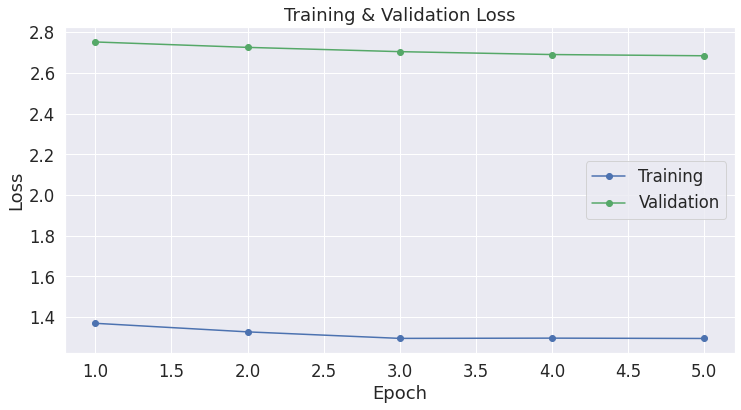

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Download the Data

In [ ]:
#Save the label2id_df in Drive 
label2id_df = pd.DataFrame([label2id] )
label2id_df.to_csv(label2id_df_path  , encoding='utf-8', index=False) 
print("\nSaved label2id_df")


Saved label2id_df


In [ ]:
#Save the Encoded Test Data in Drive 
encoded_test = pd.DataFrame(encoded_dataset['test'])
encoded_test.to_csv(encoded_test_data_path , encoding='utf-8', index=False)
print("\nSaved Encoded Test Data")


Saved Encoded Test Data


In [ ]:
#Save the Test Data in drive
used_test_df =pd.DataFrame(dataset_clean['test'])
used_test_df.to_csv(used_test_data_path, encoding='utf-8', index=False)
print("\nSaved Test Data")


Saved Test Data
